<a href="https://colab.research.google.com/github/vioneers/3D-Laser-Fabrication-of-Conical-Fiber-Tips/blob/main/labs/notebooks/multimodal/vlm_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Language Models with Gemma 3

This notebook is an exercise to understand how to process interleaved text and image inputs for a Vision Language Model (VLM) like Gemma 3. You will implement the tokenization process step-by-step.

## Setup

First, let's import the necessary libraries

In [1]:
# Uncomment if you're on colab
!git clone https://github.com/lxmls/lxmls-toolkit.git
%cd lxmls-toolkit
!git checkout student
!curl -LsSf https://astral.sh/uv/install.sh | sh
!uv sync --extra cu124

Streaming output truncated to the last 5000 lines.
⠹ Preparing packages... (139/148)
nvidia-cusolver-cu12      ------------------------------ 79.38 MiB/122.01 MiB
nvidia-cusparselt-cu12    ------------------------------ 77.20 MiB/143.11 MiB
nvidia-nccl-cu12          ------------------------------ 79.82 MiB/179.91 MiB
nvidia-cusparse-cu12      ------------------------------ 79.32 MiB/197.84 MiB
nvidia-cufft-cu12         ------------------------------ 80.34 MiB/201.66 MiB
triton                    ------------------------------ 77.43 MiB/241.43 MiB
nvidia-cublas-cu12        ------------------------------ 79.80 MiB/346.60 MiB
nvidia-cudnn-cu12         ------------------------------ 79.89 MiB/633.96 MiB
⠹ Preparing packages... (139/148)
nvidia-cusolver-cu12      ------------------------------ 79.63 MiB/122.01 MiB
nvidia-cusparselt-cu12    ------------------------------ 77.48 MiB/143.11 MiB
nvidia-nccl-cu12          ------------------------------ 79.99 MiB/179.91 MiB
nvidia-cusparse-cu12   

In [ ]:
# Uncomment if you're on a Mac with M-series chips
# import os
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
import random
from pathlib import Path
from typing import Any, Sequence, Union, List, Tuple

import numpy as np
import torch
from PIL import Image
from huggingface_hub import snapshot_download

from lxmls.multimodal.gemma3 import config
from lxmls.multimodal.gemma3.config import GemmaConfig
from lxmls.multimodal.gemma3.model import Gemma3ForMultimodalLM
from lxmls.multimodal.gemma3.processor import TokenisationOutput, Tokenizer, batch_input_preprocessor
from lxmls.multimodal.gemma3.utils import set_default_tensor_type, display_prompt_and_result, format_prompt
from lxmls.multimodal.gemma3.siglip_vision import SiglipVisionModelConfig

## Exercise: Tokenizing Raw Input

The core of this exercise is to implement the `tokenize_raw_input` function. This function takes a batch of prompts, where each prompt is a sequence of strings and PIL Images, and converts it into tensors that the Gemma 3 model can understand.

We will build this function step-by-step.

### Step 1: Tokenisation with Image Placeholders

Your first task is to implement the `tokenize_without_padding` function. This function will process a single prompt, which is a sequence of text and image tensors.

Your implementation should:
1. Begin the `token_ids` list with the beginning-of-sequence token. Use `tokenizer.bos_id` to access the token.
2. For each element in the input `prompt`:
    - If the element is a string, tokenize it using `tokenizer.encode()` and append the resulting tokens to `token_ids`. Ensure you don't add extra `bos` or `eos` tokens during this step.
    - If the element is an image, you will have to insert special tokens into `token_ids` to mark its place. For each image, Gemma 3 demands:
        - 1 Double Newline (`\n\n`) token
        - 1 Beginning-of-image token (`tokenizer.boi_id`)
        - ? Image placeholder tokens (`tokenizer.image_token_placeholder_id`). How many placeholder tokens do you think we should be adding? 1? 3? Look at the output of the vision model in `lxmls/multimodal/gemma3/siglip_vision/model.py`
        - 1 End-of-image token (`tokenizer.eoi_id`)
        - 1 Double Newline (`\n\n`) token again
    - Collect the images in a separate list, we'll need to pass them into our vision encoder later in our model `forward()`.
3. Return the a tuple containing the list of tokens and the list of images.

In [3]:
def tokenize_without_padding(
    prompt: Sequence[str | torch.Tensor],
    tokenizer: Tokenizer,
    vis_cfg: SiglipVisionModelConfig,
) -> Tuple[list[int], list[torch.Tensor]]:
    """
    Processes a single preprocessed prompt containing text and image tensors.

    Args:
        prompt: A sequence of strings and preprocessed image tensors
        tokenizer: The tokenizer instance
        vis_cfg: The configuration for the SigLIP encoder in the Gemma 3 model

    Returns:
        A tuple containing:
        1. A list of token IDs for the prompt.
        2. A list of image tensors found in the prompt.
    """
    token_ids: List[int] = []
    images: List[torch.Tensor] = []

    ### BEGIN SOLUTION

    # 1. Insert the beggining of sequence token
    token_ids.append(tokenizer.bos_id)
    for element in prompt:
      if isinstance(element,str):
        # 2.1. Tokenize text and add to token_ids
        tokens = tokenizer.encode(element, bos = False, eos = False)
        token_ids.extend(tokens)
      elif isinstance(element, torch.Tensor):
        # 2.2. Add placeholder tokens + special tokens for the image
        # You need encoding_sequence_length placeholder tokens for each image
        # as the SigLIP encoder outputs 'encoding_sequence_length' features with 'embedding_dim' dims each for each image.
        token_ids.extend(tokenizer.encode("\n\n", bos = False, eos = False))
        token_ids.append(tokenizer.boi_id)
        token_ids.extend([tokenizer.image_token_placeholder_id] * vis_cfg.encoding_sequence_length)
        token_ids.append(tokenizer.eoi_id)
        token_ids.extend(tokenizer.encode("\n\n", bos = False, eos = False))

        #2.3. Store the image tensor in a separate list
        images.append(element)

    ### END SOLUTION

    return token_ids, images

### Step 2: Padding Token Sequences

Models process inputs in batches for efficiency. However, the token sequences for different prompts in a batch will likely have different lengths. To create a single tensor from these sequences, they must all be padded to the same length.

Your task is to implement the `pad_token_sequences` function. This function will take a list of token sequences (each being a list of integers) and pad them all to a `max_seq_len`.

Your implementation should:
1. Take `all_token_ids` (a list of lists of ints), `max_seq_len`, and `pad_id` as input.
2. For each `token_ids` sequence in `all_token_ids`:
    - Calculate the number of padding tokens needed to reach `max_seq_len`.
    - Create a new list by appending the required number of `pad_id` tokens to the end of the original `token_ids` sequence.
3. Return a list containing all the new, padded token sequences.

In [4]:
def pad_token_sequences(all_token_ids: List[List[int]], max_seq_len: int, pad_id: int) -> List[List[int]]:
    """
    Pads each token sequence in a batch to a specified maximum length.

    Args:
        all_token_ids: A list where each item is a list of token IDs
        max_seq_len: The target length to pad all sequences to
        pad_id: The token ID used for padding

    Returns:
        A list of padded token ID sequences
    """
    finalised_token_ids: List[List[int]] = []

    ### BEGIN SOLUTION
    for token_ids in all_token_ids:
        pad_length = max_seq_len - len(token_ids)
        padded_token_ids = token_ids + [pad_id] * pad_length
        finalised_token_ids.append(padded_token_ids)
    ### END SOLUTION

    return finalised_token_ids

### Step 3: Padding Image Sequences

Similar to token sequences, the number of images can vary between prompts in a batch. We need to pad the list of images for each prompt so that they all have the same number of images. This allows us to stack them into a single batch tensor.

Your task is to implement the `pad_image_sequences` function.
This function will also create a boolean mask to distinguish real images from padding.

Your implementation should:
1. For each `images` list in `all_images`:
    - Calculate the number of padding images needed to reach `max_num_images`.
    - Create a `presence_mask` list of booleans, with `True` for each real image.
    - If padding is needed:
        - Create a zero-filled tensor with the correct image dimensions (`vis_cfg.input_channels`, `vis_cfg.image_size`, `vis_cfg.image_size` in that order) to serve as a padding image.
        - Extend the `images` list with the required number of padding tensors.
        - Extend the `presence_mask` list with `False` for each padding image.
2. Return the padded batch of images and the corresponding presence mask.

In [5]:
def pad_image_sequences(
    all_images: List[List[torch.Tensor]],
    max_num_images: int,
    vis_cfg: SiglipVisionModelConfig,
    device: Any,
) -> Tuple[List[List[torch.Tensor]], List[List[bool]]]:
    """
    Pads each list of images in a batch to a specified maximum number.

    Args:
        all_images: A batch of image patch tensors.
        max_num_images: The target number of images for each sequence in the batch.
        vis_cfg: The vision configuration to get image dimensions.
        device: The torch device for creating padding tensors.

    Returns:
        A tuple containing:
        1. The padded batch of image patch tensors
        2. A corresponding presence mask array (True for real images, False for padding)
    """
    image_batch: List[List[torch.Tensor]] = []
    image_presence_mask: List[List[bool]] = []


    ### BEGIN SOLUTION
    if max_num_images == 0:
        return image_batch, image_presence_mask

    for images in all_images:
        pad_length = max_num_images - len(images)
        padded_images = images.copy()
        presence_mask = [True] * len(images)

        if pad_length > 0:
            img_shape = (vis_cfg.input_channels, vis_cfg.image_size, vis_cfg.image_size)
            padding_tensor = torch.zeros(img_shape, device=device)
            padded_images.extend([padding_tensor] * pad_length)
            presence_mask.extend([False] * pad_length)

        image_batch.append(padded_images)
        image_presence_mask.append(presence_mask)
    ### END SOLUTION

    return image_batch, image_presence_mask

### Putting it all together

We've put together the main `tokenize` function, which orchestrates the entire tokenization process for a batch of prompts.
This function will use the helper functions you've just completed.

The overall process is:
1. **Preprocess Inputs**: Use `batch_input_preprocessor` to convert PIL Images in the raw input into preprocessed `torch.Tensor`s.
2. **Tokenize Each Prompt**: Iterate through the `preprocessed_batch`. For each prompt, call your `tokenize_without_padding` function to get the token IDs and image tensors. Store these in `all_token_ids` and `all_images` lists, and also record the length of each token sequence.
3. **Calculate Padding Dimensions**: Determine the `max_seq_len` for the batch by adding `output_len` to the maximum prompt length. Also, find the `max_num_images` across all prompts in the batch.
4. **Pad Sequences**: Call your `pad_token_sequences` and `pad_image_sequences` functions with the appropriate arguments to pad the token and image lists.
5. **Create Tensors**: Convert the padded lists of token IDs, images, and the image presence mask into `torch.Tensor`s. The image batch requires stacking the tensors twice. Handle the case where there are no images in the batch gracefully (the image batch and mask should be `None`).
6. **Return Output**: Package all the final tensors and metadata into a `TokenisationOutput` object and return it.

In [6]:
def tokenize(
    tokenizer: Tokenizer,
    input: Sequence[Sequence[Union[str, Image.Image]]],
    config: GemmaConfig,
    output_len: int,
    device: Any,
) -> TokenisationOutput:
    """
    Converts a preprocessed batch of interleaved text and image inputs into
    token IDs and an image batch suitable for the Gemma model.

    This function orchestrates calls to several helper functions that process
    individual prompts and handle padding.

    Args:
        tokenizer: The tokenizer for converting text to token IDs.
        raw_input: A batch of user inputs, where each input is a sequence
                   of strings and PIL Images.
        config: The model configuration containing vision settings.
        output_len: The desired length of the output sequence.
        device: The torch device to place tensors on.

    Returns:
        A TokenisationOutput object containing the tokenized inputs and image batch.
    """
    vis_cfg = config.vision_config
    assert vis_cfg is not None

    preprocessed_batch = batch_input_preprocessor(input)

    # --- Process each prompt in the batch ---
    all_token_ids: List[List[int]] = []
    all_images: List[List[torch.Tensor]] = []
    prompt_lengths: List[int] = []

    for prompt in preprocessed_batch:
        token_ids, images = tokenize_without_padding(prompt, tokenizer, vis_cfg)
        all_token_ids.append(token_ids)
        all_images.append(images)
        prompt_lengths.append(len(token_ids))

    # --- Calculate padding dimensions ---
    min_prompt_len = min(prompt_lengths) if prompt_lengths else 0
    max_prompt_len = max(prompt_lengths) if prompt_lengths else 0
    max_seq_len = max_prompt_len + output_len
    max_num_images = max(len(images) for images in all_images) if all_images else 0

    # --- Pad the token and image sequences ---
    finalised_token_ids_list = pad_token_sequences(all_token_ids, max_seq_len, tokenizer.pad_id)
    image_batch_list, image_presence_mask_list = pad_image_sequences(all_images, max_num_images, vis_cfg, device)

    # --- Convert lists to tensors ---
    finalised_token_ids = torch.tensor(finalised_token_ids_list, dtype=torch.long, device=device)

    if max_num_images > 0:
        image_batch = torch.stack([torch.stack(images) for images in image_batch_list]).to(device=device, dtype=config.get_dtype())
        image_presence_mask = torch.tensor(image_presence_mask_list, dtype=torch.bool, device=device)
    else:
        image_batch = None
        image_presence_mask = None

    # --- Prepare and return the final output ---
    return TokenisationOutput(
        finalised_token_ids=finalised_token_ids,
        image_batch=image_batch,
        batch_size=len(preprocessed_batch),
        min_prompt_len=min_prompt_len,
        max_prompt_len=max_prompt_len,
        max_seq_len=max_seq_len,
        image_presence_mask=image_presence_mask,
    )

### The `generate` function

We provide the `generate` function for you. It uses your `tokenize_raw_input` function to prepare the data and then runs the model to generate text.<br>
Read through to get a feel for multimodal inference in current state-of-the-art open-source multimodal models.

In [7]:
def generate(
    model: Gemma3ForMultimodalLM,
    prompts: Sequence[Sequence[Union[str, Image.Image]]],
    device: Any,
    output_len: int = 100,
    temperature: Union[float, None] = 1.0,
    top_p: float = 0.95,
    top_k: int = 64,
) -> Sequence[str]:
    processing_result = tokenize(model.tokenizer, prompts, model.config, output_len, device)
    batch_size = processing_result.batch_size
    finalised_token_ids = processing_result.finalised_token_ids
    image_batch = processing_result.image_batch
    min_prompt_len = processing_result.min_prompt_len
    _max_prompt_len = processing_result.max_prompt_len
    total_seq_len = processing_result.max_seq_len
    image_presence_mask = processing_result.image_presence_mask

    # Create attention mask.
    assert model.dtype is not None
    min_dtype = torch.finfo(model.dtype).min
    n_inf = torch.tensor(min_dtype, dtype=model.dtype, device=device)
    assert model.config.sliding_window_size is not None
    boolean_mask, local_boolean_mask = model.create_attention_mask(finalised_token_ids, total_seq_len)
    mask_tensor = torch.where(boolean_mask, 0, n_inf).contiguous()
    local_mask_tensor = torch.where(local_boolean_mask, 0, n_inf).contiguous()

    kv_caches = []
    for _ in range(model.config.num_hidden_layers):
        size = (batch_size, total_seq_len, model.config.num_key_value_heads, model.config.head_dim)
        dtype = model.config.get_dtype()
        k_cache = torch.zeros(size=size, dtype=dtype, device=device)
        v_cache = torch.zeros(size=size, dtype=dtype, device=device)
        kv_caches.append((k_cache, v_cache))

    input_token_ids_tensor = torch.full(
        (batch_size, min_prompt_len), model.tokenizer.pad_id, dtype=torch.int64, device=device
    )
    token_ids_tensor = finalised_token_ids.to(device)
    for i in range(batch_size):
        p = finalised_token_ids[i]
        input_token_ids_tensor[i, :min_prompt_len] = p[:min_prompt_len]

    input_positions_tensor = torch.arange(0, min_prompt_len, dtype=torch.int64, device=device)
    prompt_mask_tensor = token_ids_tensor != model.tokenizer.pad_id
    curr_mask_tensor = mask_tensor.index_select(2, torch.atleast_1d(input_positions_tensor))
    curr_local_mask_tensor = local_mask_tensor.index_select(2, torch.atleast_1d(input_positions_tensor))
    # The first iteration produces a sequence of hidden states of shape: [B, min_prompt_len, hidden_size]
    # To predict the next token, we need to look at the hidden state corresponding to the last token: [min_prompt_len - 1]
    output_positions_tensor = torch.LongTensor([min_prompt_len - 1]).to(device)
    temperatures_tensor = None if not temperature else torch.FloatTensor([temperature] * batch_size).to(device)
    top_ps_tensor = torch.FloatTensor([top_p] * batch_size).to(device)
    top_ks_tensor = torch.LongTensor([top_k] * batch_size).to(device)
    output_index = torch.tensor(min_prompt_len, dtype=torch.int64, device=device)

    # Prefill up to min_prompt_len tokens, then treat other prefill as
    # decode and ignore output.
    for i in range(total_seq_len - min_prompt_len):
        next_token_ids, _ = model(
            input_token_ids=input_token_ids_tensor,
            image_patches=image_batch,  # NOTE: Always `None` after the first iteration
            image_presence_mask=image_presence_mask,
            input_positions=input_positions_tensor,
            kv_caches=kv_caches,
            mask=curr_mask_tensor,
            output_positions=output_positions_tensor,
            temperatures=temperatures_tensor,
            top_ps=top_ps_tensor,
            top_ks=top_ks_tensor,
            local_mask=curr_local_mask_tensor,
        )
        # Check if the current generation step corresponds to a position that was part of the original prompt
        curr_prompt_mask = prompt_mask_tensor.index_select(1, torch.atleast_1d(output_index)).squeeze(dim=1)
        # Retrieve the token from the original prompt at the current position
        curr_token_ids = token_ids_tensor.index_select(1, torch.atleast_1d(output_index)).squeeze(dim=1)
        # Decide which token to use
        # if `curr_prompt_mask` is True (i.e. we are still processing the prompt) use prompt token curr_token_ids
        # else use the token generated by the model: next_token_ids
        output_token_ids = torch.where(curr_prompt_mask, curr_token_ids, next_token_ids).unsqueeze(dim=1)
        # Update the 'final' copy of tokens
        token_ids_tensor.index_copy_(dim=1, index=output_index, source=output_token_ids)

        # Token just generated (or prefilled) is not part of the input
        input_token_ids_tensor = output_token_ids
        # The input position for the next iteration is set to the current output_index
        input_positions_tensor = output_index.unsqueeze(dim=-1)
        # The attention masks are updated to reflect the new seq_len for the next iteration
        curr_mask_tensor = mask_tensor.index_select(2, torch.atleast_1d(input_positions_tensor))
        curr_local_mask_tensor = (
            local_mask_tensor.index_select(2, torch.atleast_1d(input_positions_tensor)) if local_mask_tensor is not None else None
        )
        # After the first iteration, where we pass in min_prompt_len tokens, we now generate tokens one by one
        # The input to the model now becomes a single token
        # The model processes this token and produces a hidden state sequence of shape: [B, 1, hidden_size]
        # So, now to get the logits for the next token, we need to use the first (and only) hidden state available
        output_positions_tensor = torch.tensor(0, dtype=torch.int64, device=device)
        # duh
        output_index = output_index + 1

        # The image information is already integrated into the text embeddings in the first iteration
        image_batch = None
        image_presence_mask = None

    # Detokenization.
    token_ids = token_ids_tensor.tolist()
    results = []
    for i, tokens in enumerate(token_ids):
        output = tokens
        if model.tokenizer.eos_id in output:
            eos_index = output.index(model.tokenizer.eos_id)
            output = output[:eos_index]
        results.append(model.tokenizer.decode(output))

    return results

## Testing the Full Pipeline

Now we can test the entire pipeline with different types of prompts.
<br>
We start by defining a few arguments. Feel free to change them according to your device and requirements.

In [8]:
# If you're on colab, you might want to change these paths
class Args:
    model_dir: str = "../../../data/vlm/gemma3"
    image_dir: str = "../../../data/vlm/images"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    output_len: int = 128
    seed: int = 42
    quant: bool = True


args = Args()

# Create directories if they don't exist
Path(args.model_dir).mkdir(parents=True, exist_ok=True)
Path(args.image_dir).mkdir(parents=True, exist_ok=True)

### Download Model

Next, we download the Gemma 3 model weights and tokenizer model.

In [9]:
snapshot_download("rshwndsz/gemma-3-4b-it-ckpt-int8", local_dir=args.model_dir)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/4.75G [00:00<?, ?B/s]

'/data/vlm/gemma3'

### Load Model

Now, we load the model into memory. This might take a few moments.

In [10]:
# Construct the model config
model_config = config.get_model_config()
model_config.dtype = "float32"
model_config.quant = args.quant
model_config.tokenizer = str(Path(args.model_dir) / "tokenizer.model")

# Reproducibility settings
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# Instantiate model and load weights
device = torch.device(args.device)
with set_default_tensor_type(model_config.get_dtype()):
    model = Gemma3ForMultimodalLM(model_config)
    model.load_state_dict(torch.load(Path(args.model_dir) / "model.ckpt")["model_state_dict"])
    model = model.to(device).eval()

print("Model loading done")

Model loading done


### Text-Only Generation

In [2]:
prompts = [
    format_prompt(["Write a poem about a chonky cat."]),
]
results = generate(
    model,
    prompts,
    device,
    output_len=args.output_len,
)

for prompt, result in zip(prompts, results):
    display_prompt_and_result(prompt, result)

NameError: name 'format_prompt' is not defined

### Generation with a Single Image

In [3]:
golden_test_image_path = Path(args.image_dir) / "test_image.jpg"
prompts = [
    format_prompt([Image.open(golden_test_image_path), "Caption this image."]),
]
results = generate(
    model,
    prompts,
    device,
    output_len=args.output_len,
)

for prompt, result in zip(prompts, results):
    display_prompt_and_result(prompt, result)

NameError: name 'Path' is not defined

INPUT
<start_of_turn>user


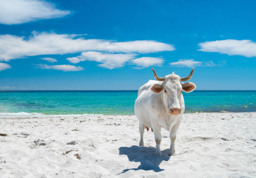

The name of the animal in the image is<end_of_turn>
<start_of_turn>model
 --------------------------------------------------------------------------------
GENERATED
<start_of_turn>user


<start_of_image><end_of_image>

The name of the animal in the image is<end_of_turn>
<start_of_turn>model

Based on the image, the animal is a **cow**. It appears to be a white cow with horns.


In [ ]:
cow_in_beach_path = Path(args.image_dir) / "cow_in_beach.jpg"
prompts = [
    format_prompt([Image.open(cow_in_beach_path), "The name of the animal in the image is"]),
]
results = generate(
    model,
    prompts,
    device,
    output_len=args.output_len,
)

for prompt, result in zip(prompts, results):
    display_prompt_and_result(prompt, result)

### Generation with Interleaved Image & Text

INPUT
<start_of_turn>user
This image

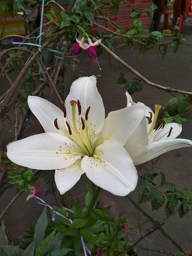

and this image

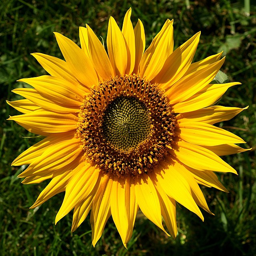

are similar because? Give me the main reason.<end_of_turn>
<start_of_turn>model
 --------------------------------------------------------------------------------
GENERATED
<start_of_turn>user
This image

<start_of_image><end_of_image>

and this image

<start_of_image><end_of_image>

are similar because? Give me the main reason.<end_of_turn>
<start_of_turn>model

The main reason the two images are similar is that they both feature **large, bright yellow flowers with prominent petals radiating outwards.** 

Specifically, the first image shows a white lily with yellow stamens, while the second shows a sunflower. Both have a bold, sunny appearance and a focus on the central disc/seed head.


In [ ]:
lilly_path = Path(args.image_dir) / "lilly.jpg"
sunflower_path = Path(args.image_dir) / "sunflower.jpg"
prompts = [
    format_prompt(
        [
            "This image",
            Image.open(lilly_path),
            "and this image",
            Image.open(sunflower_path),
            "are similar because? Give me the main reason.",
        ]
    ),
]
results = generate(
    model,
    prompts,
    device,
    output_len=args.output_len,
)

for prompt, result in zip(prompts, results):
    display_prompt_and_result(prompt, result)